# Distinguish noise from chaos

### TS embedding

In [36]:
import math
import numpy as np
import itertools
from tqdm import tqdm

def time_series_embedding(series, D=6):
    result = np.zeros(shape=(math.factorial(D)))
    y = len(series) - D + 1

    for i in tqdm(range(y)):
        for index, j in enumerate(itertools.permutations(range(D))):
            pattern = series[i:i+D][list(j)]
            if np.all(pattern[:-1] <= pattern[1:]):
                result[index] += 1
                break
    return result / y

### Complexity and entropy implementation

In [28]:
def shenons_entropy(P):
    P = np.array(P[P != 0])
    return -((P * np.log(P)).sum())

def entropic_measure(P):
    S_max = shenons_entropy(np.ones(len(P))/len(P))
    return shenons_entropy(P) / S_max

def jensen_shannon_divergence(P_1, P_2):
    N = len(P_1)
    Q_0 = -2 / ((N+1)/N * np.log(N+1) - 2 * np.log(2 * N) + np.log(N))
    return Q_0 * (shenons_entropy((P_1 + P_2)/2) - shenons_entropy(P_1)/2 - shenons_entropy(P_2)/2)

def complexity(P):
    return jensen_shannon_divergence(P, np.ones(len(P))/len(P)) * entropic_measure(P)

### Min and max borders generation

In [29]:
import math

def min_borders(d, n_steps = 500):
    N = math.factorial(d)
    d_step = (1 - 1 / N) / n_steps

    p_min = np.arange(1/N, 1, d_step)
    min_complexity = []
    min_entropy = []

    for i in range(len(p_min)):
        P = []
        if p_min[i] > 1:
            p_min[i] = 1
        P.append(p_min[i])
        for j in range(N-1):
            p_rest  = (1 - p_min[i]) / (N - 1)
            P.append(p_rest)
        P = np.array(P)
        min_entropy.append(entropic_measure(P))
        min_complexity.append(complexity(P))

    return min_entropy, min_complexity

def max_borders(d, n_steps = 500):
    N = math.factorial(d)
    d_step = (1 - 1 / N) / n_steps

    
    max_complexity = []
    max_entropy = []

    for i in range(N - 1):
        p_max = np.arange(0, 1 / (N - i), d_step)
        
        for j in range(len(p_max)):
            P = [p_max[j]]
            p_rest = (1 - p_max[j]) / (N - i - 1)
            for _ in range(N - i - 1):
                P.append(p_rest)

            if len(P) != N:
                P = np.pad(P, (0, i), mode='constant')

            P = np.array(P)

            max_entropy.append(entropic_measure(P))
            max_complexity.append(complexity(P))

    return max_entropy, max_complexity


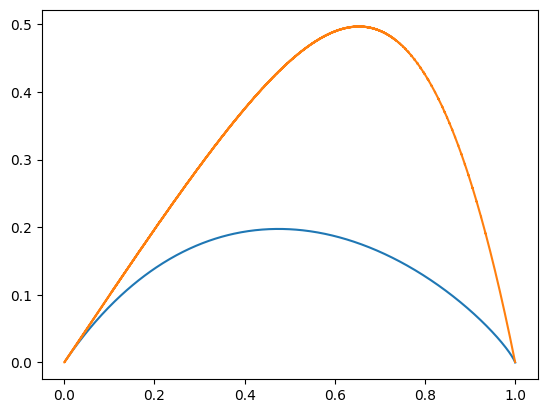

In [30]:
import matplotlib.pyplot as plt

# Check borders
X, y = min_borders(6)
plt.plot(X, y)
X, y = max_borders(6)
plt.plot(X, y)
plt.show()

### TS Generation

#### Chaotic

In [31]:
# Skew tent map
def skew_tent_map(n=2**15, omega=0.1847, x0=.5):
    x = np.zeros(n)
    x[0] = x0
    for i in range(1, len(x)):
        if x[i-1] < omega:
            x[i] = x[i-1]/omega
        else:
            x[i] = (1-x[i-1])/(1-omega)
    return x


# Logistic map
def logistic_map(n=2**15, r=4, x0=.4):
    x = np.zeros(n)
    x[0] = x0
    for i in range(n-1):
        x[i+1] = r*x[i]*(1-x[i])
    return x


# Schuster's map
def schuster_map(n=2**15, z=2, x0=.5):  
    z = float(z)
    x = np.zeros(n)
    x[0] = x0
    for i in range(1, n):
        x[i], _ = np.modf(x[i-1] + x[i-1]**z)
    return x


# Henon map
def henon_map(n=1000000, a=1.4, b=0.3, x0=.4):
    x = np.zeros(n)
    x[0] = x0
    for i in range(1, len(x)):
        x[i] = 1 - a * x[i-1] ** 2 + b * x[i-1]
    return x


# Lorenz ts
def lorenz_ts():
    x = np.array([])
    with open("lorenz.txt") as f:
        for line in f:
            x = np.append(x, float(line))
    return x


#### Regular ts

In [32]:
sine_data = np.sin(np.arange(0,1000,.01))

#### Noise

In [33]:
gaussian_noise = np.random.normal(size=100000)

### TS embedding 

In [34]:
skew = skew_tent_map()
logistic = logistic_map()
schuster2 = schuster_map()
schuster3_2 = schuster_map(z=3/2)
schuster5_2 = schuster_map(z=5/2)
henon = henon_map()
lorenz = lorenz_ts()

In [37]:
skew_p = time_series_embedding(skew)
logistic_p = time_series_embedding(logistic)
schuster2_p = time_series_embedding(schuster2)
schuster3_2_p = time_series_embedding(schuster3_2)
schuster5_2_p = time_series_embedding(schuster5_2)
henon_p = time_series_embedding(henon)
lorenz_p = time_series_embedding(lorenz)

100%|██████████| 99996/99996 [03:17<00:00, 506.27it/s]


In [38]:
sine_p = time_series_embedding(sine_data)
gaussian_noise_p = time_series_embedding(gaussian_noise)

100%|██████████| 99995/99995 [03:13<00:00, 518.08it/s]


### Count entropy and complexity

In [39]:
skew_c = complexity(skew_p)
skew_e = entropic_measure(skew_p)

logistic_c = complexity(logistic_p)
logistic_e = entropic_measure(logistic_p)

schuster2_c = complexity(schuster2_p)
schuster2_e = entropic_measure(schuster2_p)

schuster3_2_c = complexity(schuster3_2_p)
schuster3_2_e = entropic_measure(schuster3_2_p)

schuster5_2_c = complexity(schuster5_2_p)
schuster5_2_e = entropic_measure(schuster5_2_p)

henon_c = complexity(henon_p)
henon_e = entropic_measure(henon_p)

lorenz_c = complexity(lorenz_p)
lorenz_e = entropic_measure(lorenz_p)

sine_c = complexity(sine_p)
sine_e = entropic_measure(sine_p)

gaussian_noise_c = complexity(gaussian_noise_p)
gaussian_noise_e = entropic_measure(gaussian_noise_p)

### Plotting TS

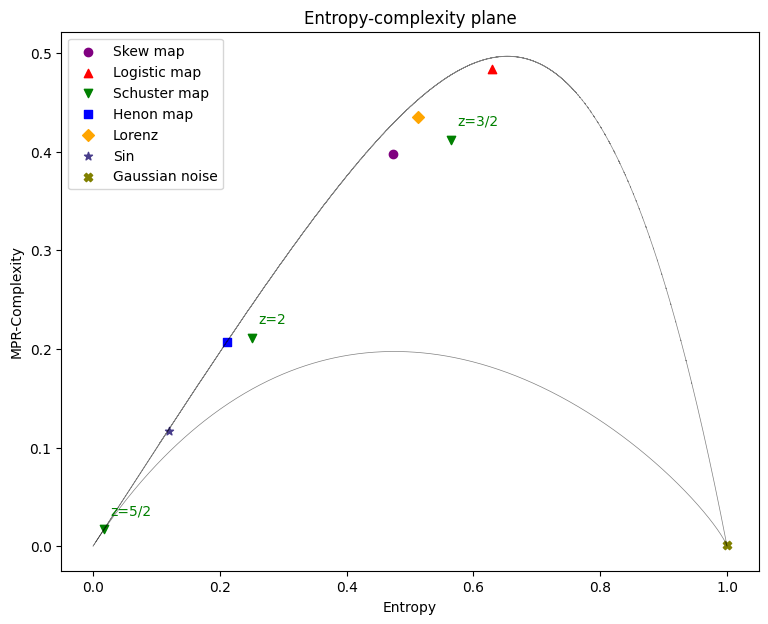

In [68]:
plt.figure(figsize=(9, 7))

ax = plt.gca()
X, y = min_borders(6)
plt.plot(X, y, linewidth=0.5, alpha=0.5, c="black")
X, y = max_borders(6)
plt.plot(X, y, linewidth=0.5, alpha=0.5, c="black")


plt.scatter(skew_e, skew_c, c="purple", marker='o', label="Skew map")
plt.scatter(logistic_e, logistic_c, c="red", marker='^', label="Logistic map")
schuster_es = [schuster2_e, schuster3_2_e, schuster5_2_e]
schuster_cs = [schuster2_c, schuster3_2_c, schuster5_2_c]
plt.scatter(schuster_es, schuster_cs, c="green", marker='v', label="Schuster map")
for index, text in enumerate(['z=2', 'z=3/2', 'z=5/2']):
    ax.annotate(text, xy=(schuster_es[index] + 0.01, schuster_cs[index] + 0.015), c="green")
plt.scatter(henon_e, henon_c, c="blue", marker='s', label="Henon map")
plt.scatter(lorenz_e, lorenz_c, c="orange", marker='D', label="Lorenz")
plt.scatter(sine_e, sine_c, c="darkslateblue", marker='*', label="Sin")
plt.scatter(gaussian_noise_e, gaussian_noise_c, c="olive", marker='X', label="Gaussian noise")
plt.legend()
plt.title("Entropy-complexity plane")

ax.set_xlabel("Entropy")
ax.set_ylabel("MPR-Complexity")

plt.show()